In [54]:
import pandas as pd
import numpy as np
import torch

import seaborn as sns

from scipy.stats import pearsonr

from tqdm import tqdm

### Preprocess data

In [403]:
smell_vectors = pd.read_csv('../results/features/mono-descriptors-v1.csv',
                           sep=',', index_col=0)
### zscore
smell_vectors = (smell_vectors - smell_vectors.mean()) / smell_vectors.std()
### padding
smell_vectors.loc[0] = 0
smell_vectors = smell_vectors.sort_index()

In [404]:
### map CID to index
mapping = pd.Series(range(len(smell_vectors.index)), index=smell_vectors.index)

In [406]:
mixtures_tr = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_Training_set.csv')
mixtures_lb = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_Leaderboard_set.csv')
mixtures_ts = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_test_set.csv')
mixtures_tr.index = mixtures_tr['Dataset'] + '_' + mixtures_tr['Mixture Label'].astype(str)
mixtures_lb.index = mixtures_lb['Dataset'] + '_' + mixtures_lb['Mixture Label'].astype(str)
mixtures_ts.index = mixtures_ts['Mixture Label'].astype(str)
mixtures_tr = mixtures_tr.iloc[:, 2:]
mixtures_lb = mixtures_lb.iloc[:, 2:]
mixtures_ts = mixtures_ts.iloc[:, 1:]

In [407]:
### replace missing cids with 0
for i in mixtures_tr.index:
    for c in mixtures_tr.columns:
        comp = mixtures_tr.loc[i, c]
        if comp not in smell_vectors.index:
            mixtures_tr.loc[i, c] = 0

for i in mixtures_lb.index:
    for c in mixtures_lb.columns:
        comp = mixtures_lb.loc[i, c]
        if comp not in smell_vectors.index:
            mixtures_lb.loc[i, c] = 0


for i in mixtures_ts.index:
    for c in mixtures_ts.columns:
        comp = mixtures_ts.loc[i, c]
        if comp not in smell_vectors.index:
            mixtures_ts.loc[i, c] = 0

In [408]:
### cid - index mapping
for c in mixtures_tr.columns:
    mixtures_tr[c] = mixtures_tr[c].map(mapping)

for c in mixtures_lb.columns:
    mixtures_lb[c] = mixtures_lb[c].map(mapping)

for c in mixtures_ts.columns:
    mixtures_ts[c] = mixtures_ts[c].map(mapping)

In [409]:
pairs_df_tr = pd.read_csv('../data/olfaction_mixture/TrainingData_mixturedist.csv')
fil = pairs_df_tr.isna().sum(1)<4
pairs_df_tr = pairs_df_tr[fil]
pairs_df_tr['Mixture 1'] = pairs_df_tr['Dataset'] + '_' + pairs_df_tr['Mixture 1'].astype(int).astype(str)
pairs_df_tr['Mixture 2'] = pairs_df_tr['Dataset'] + '_' + pairs_df_tr['Mixture 2'].astype(int).astype(str)
pairs_df_tr = pairs_df_tr.iloc[:, 1:]

In [410]:
pairs_df_lb = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
pairs_df_lb['Mixture 1'] = pairs_df_lb['Dataset'] + '_' + pairs_df_lb['Mixture_1'].astype(int).astype(str)
pairs_df_lb['Mixture 2'] = pairs_df_lb['Dataset'] + '_' + pairs_df_lb['Mixture_2'].astype(int).astype(str)
pairs_df_lb = pairs_df_lb[['Mixture 1', 'Mixture 2', 'Predicted_Experimental_Values']]
pairs_df_lb.columns = ['Mixture 1', 'Mixture 2', 'Experimental Values']

In [411]:
pairs_df_ts = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')
pairs_df_ts['Mixture 1'] = pairs_df_ts['Mixture_1'].astype(int).astype(str)
pairs_df_ts['Mixture 2'] = pairs_df_ts['Mixture_2'].astype(int).astype(str)
pairs_df_ts = pairs_df_ts[['Mixture 1', 'Mixture 2', 'Predicted_Experimental_Values']]
pairs_df_ts.columns = ['Mixture 1', 'Mixture 2', 'Experimental Values']

In [412]:
### train and validation data for testing the model
tr = list(np.random.choice(pairs_df_tr.index, 400, False))
ts = list(set(pairs_df_tr.index) - set(tr))
pairs_df_tr_tr = pairs_df_tr.loc[tr]
pairs_df_tr_val = pairs_df_tr.loc[ts]

### Dataloader

In [413]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class OdorantDataset(Dataset):
    def __init__(self, composition_df, pairs_df, smell_vectors):
        self.composition_df = composition_df
        self.pairs_df = pairs_df
        self.smell_vectors = smell_vectors
        self.mixture_dict = self._build_mixture_dict()
    
    def _build_mixture_dict(self):
        mixture_dict = {}
        for idx, row in self.composition_df.iterrows():
            mixture_id = idx
            chemical_ids = [x for x in list(row) if x!=0]
            mixture_dict[mixture_id] = chemical_ids
        return mixture_dict
    
    def __len__(self):
        return len(self.pairs_df)
    
    def __getitem__(self, idx):
        row = self.pairs_df.iloc[idx]
        mixture1_id = row['Mixture 1']
        mixture2_id = row['Mixture 2']
        similarity = row['Experimental Values']

        input_ids1 = torch.tensor(self.mixture_dict[mixture1_id])
        input_ids2 = torch.tensor(self.mixture_dict[mixture2_id])
        #input_ids1 = self._get_input_ids(mixture1_id)
        #input_ids2 = self._get_input_ids(mixture2_id)
        return input_ids1, input_ids2, similarity
    
    def _get_input_ids(self, mixture_id):
        chemical_ids = self.mixture_dict[mixture_id]
        input_ids = [self.smell_vectors.loc[chem_id] for chem_id in chemical_ids]
        input_ids = torch.tensor(input_ids, dtype=torch.float32)
        return input_ids

def collate_fn(batch):
    input_ids1, input_ids2, similarities = zip(*batch)
    
    input_ids1_padded = pad_sequence(input_ids1, batch_first=True)
    input_ids2_padded = pad_sequence(input_ids2, batch_first=True)
    
    attention_mask1 = (input_ids1_padded != 0).float()
    attention_mask2 = (input_ids2_padded != 0).float()
    
    similarities = torch.tensor(similarities, dtype=torch.float32)
    
    return input_ids1_padded, attention_mask1, input_ids2_padded, attention_mask2, similarities

# Create the dataset and dataloader
dataset_tr = OdorantDataset(mixtures_tr, pairs_df_tr, smell_vectors)
dataset_tr_tr = OdorantDataset(mixtures_tr, pairs_df_tr_tr, smell_vectors)
dataset_tr_val = OdorantDataset(mixtures_tr, pairs_df_tr_val, smell_vectors)
dataset_lead = OdorantDataset(mixtures_lb, pairs_df_lb, smell_vectors)
dataset_test = OdorantDataset(mixtures_ts, pairs_df_ts, smell_vectors)
train_dataloader = DataLoader(dataset_tr, batch_size=16, shuffle=True, collate_fn=collate_fn)
train_dataloader_tr = DataLoader(dataset_tr_tr, batch_size=16, shuffle=True, collate_fn=collate_fn)
train_dataloader_val = DataLoader(dataset_tr_val, batch_size=16, shuffle=False, collate_fn=collate_fn)
lead_dataloader = DataLoader(dataset_lead, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=collate_fn)

### Make model with cross-attention

In [414]:
import torch
import torch.nn as nn
import torch.optim as optim

class FixedEmbeddingLayer(nn.Module):
    def __init__(self, embedding_matrix):
        super(FixedEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
    
    def forward(self, x):
        return self.embedding(x)

class CrossAttention(nn.Module):
    def __init__(self, input_dim):
        super(CrossAttention, self).__init__()
        self.query1 = nn.Linear(input_dim, input_dim)
        self.key1 = nn.Linear(input_dim, input_dim)
        self.value1 = nn.Linear(input_dim, input_dim)

        self.query2 = nn.Linear(input_dim, input_dim)
        self.key2 = nn.Linear(input_dim, input_dim)
        self.value2 = nn.Linear(input_dim, input_dim)
        
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x1, x2, mask1, mask2):
        query1 = self.query1(x1)
        key2 = self.key2(x2)
        value2 = self.value2(x2)

        query2 = self.query2(x2)
        key1 = self.key1(x1)
        value1 = self.value1(x1)

        scores1 = torch.matmul(query1, key2.transpose(-2, -1)) / torch.sqrt(torch.tensor(x1.size(-1), dtype=torch.float32))
        scores2 = torch.matmul(query2, key1.transpose(-2, -1)) / torch.sqrt(torch.tensor(x2.size(-1), dtype=torch.float32))

        mask1 = mask1.unsqueeze(2).repeat(1, 1, x2.size(1))
        mask2 = mask2.unsqueeze(2).repeat(1, 1, x1.size(1))

        scores1 = scores1.masked_fill(mask1 == 0, -1e9)
        scores2 = scores2.masked_fill(mask2 == 0, -1e9)

        weights1 = self.softmax(scores1)
        weights2 = self.softmax(scores2)

        context1 = torch.matmul(weights1, value2).mean(dim=1)
        context2 = torch.matmul(weights2, value1).mean(dim=1)

        return context1, context2

class OdorantCrossAttentionModel(nn.Module):
    def __init__(self, embedding_matrix):
        super(OdorantCrossAttentionModel, self).__init__()
        self.embedding_layer = FixedEmbeddingLayer(embedding_matrix)
        self.cross_attention = CrossAttention(input_dim=embedding_matrix.shape[1])
        self.fc1 = nn.Linear(embedding_matrix.shape[1] * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        embeddings1 = self.embedding_layer(input_ids1)
        embeddings2 = self.embedding_layer(input_ids2)
        
        context1, context2 = self.cross_attention(embeddings1, embeddings2, attention_mask1, attention_mask2)
        
        combined = torch.cat((context1, context2), dim=1)
        x = self.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Example embedding matrix (replace with your actual smell vectors)
embedding_matrix = smell_vectors.values

def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    val_los_min = 1000
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
            optimizer.zero_grad()
            predictions = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            loss = loss_fn(predictions.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_dataloader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
                predictions = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
                loss = loss_fn(predictions.squeeze(), labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
def predict(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
            preds = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            predictions.append(preds.squeeze().numpy())
            actuals.append(labels.numpy())
    return predictions, actuals

In [415]:
### testing the model
model = OdorantCrossAttentionModel(embedding_matrix)
train_model(model, train_dataloader_tr, train_dataloader_val, epochs=200, learning_rate=1e-4)

Epoch 1/200, Train Loss: 0.2134, Validation Loss: 0.2090
Epoch 11/200, Train Loss: 0.0252, Validation Loss: 0.0268
Epoch 21/200, Train Loss: 0.0231, Validation Loss: 0.0253
Epoch 31/200, Train Loss: 0.0219, Validation Loss: 0.0258
Epoch 41/200, Train Loss: 0.0209, Validation Loss: 0.0261
Epoch 51/200, Train Loss: 0.0203, Validation Loss: 0.0259
Epoch 61/200, Train Loss: 0.0194, Validation Loss: 0.0261
Epoch 71/200, Train Loss: 0.0189, Validation Loss: 0.0253
Epoch 81/200, Train Loss: 0.0181, Validation Loss: 0.0254
Epoch 91/200, Train Loss: 0.0179, Validation Loss: 0.0244
Epoch 101/200, Train Loss: 0.0172, Validation Loss: 0.0245
Epoch 111/200, Train Loss: 0.0167, Validation Loss: 0.0239
Epoch 121/200, Train Loss: 0.0162, Validation Loss: 0.0231
Epoch 131/200, Train Loss: 0.0157, Validation Loss: 0.0225
Epoch 141/200, Train Loss: 0.0151, Validation Loss: 0.0224
Epoch 151/200, Train Loss: 0.0145, Validation Loss: 0.0227
Epoch 161/200, Train Loss: 0.0141, Validation Loss: 0.0225
Epoch 17

In [416]:
p, t = predict(model, train_dataloader_val)
p = np.concatenate(p)
t = np.concatenate(t)

In [417]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

(PearsonRResult(statistic=0.4864416977054002, pvalue=2.879292749274691e-07),
 0.020160487)

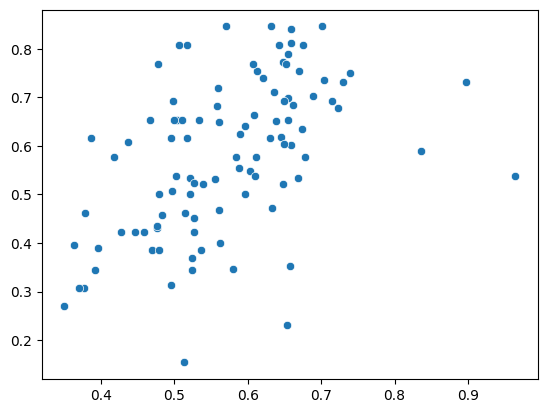

In [418]:
sns.scatterplot(x=p, y=t)
pearsonr(p, t), mean_squared_error(p, t)

In [419]:
model = OdorantCrossAttentionModel(embedding_matrix)
train_model(model, train_dataloader, train_dataloader_val, epochs=200, learning_rate=1e-4)

Epoch 1/200, Train Loss: 0.3369, Validation Loss: 0.3132
Epoch 11/200, Train Loss: 0.0270, Validation Loss: 0.0291
Epoch 21/200, Train Loss: 0.0238, Validation Loss: 0.0247
Epoch 31/200, Train Loss: 0.0220, Validation Loss: 0.0237
Epoch 41/200, Train Loss: 0.0211, Validation Loss: 0.0233
Epoch 51/200, Train Loss: 0.0207, Validation Loss: 0.0232
Epoch 61/200, Train Loss: 0.0194, Validation Loss: 0.0226
Epoch 71/200, Train Loss: 0.0194, Validation Loss: 0.0219
Epoch 81/200, Train Loss: 0.0195, Validation Loss: 0.0217
Epoch 91/200, Train Loss: 0.0184, Validation Loss: 0.0213
Epoch 101/200, Train Loss: 0.0188, Validation Loss: 0.0209
Epoch 111/200, Train Loss: 0.0181, Validation Loss: 0.0195
Epoch 121/200, Train Loss: 0.0178, Validation Loss: 0.0188
Epoch 131/200, Train Loss: 0.0179, Validation Loss: 0.0185
Epoch 141/200, Train Loss: 0.0168, Validation Loss: 0.0179
Epoch 151/200, Train Loss: 0.0158, Validation Loss: 0.0168
Epoch 161/200, Train Loss: 0.0161, Validation Loss: 0.0164
Epoch 17

In [420]:
p, t = predict(model, lead_dataloader)
p = np.concatenate(p)
t = np.concatenate(t)

In [425]:
sub = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
sub['Predicted_Experimental_Values'] = p
sub.to_csv('../results/submissions/smellformer-lead.csv', index=False)

In [426]:
p, t = predict(model, test_dataloader)
p = np.concatenate(p)
t = np.concatenate(t)

In [427]:
sub = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')
sub['Predicted_Experimental_Values'] = p
sub.to_csv('../results/submissions/smellformer-test.csv', index=False)

In [428]:
a = pd.read_csv('../results/submissions/first-version-lead.csv')
b = pd.read_csv('../results/submissions/smellformer-lead.csv')

In [ ]:
sns.scatterplot(x=a['Predicted_Experimental_Values'],
                y=